<a href="https://colab.research.google.com/github/michalSt98/Various-projects/blob/master/Msc_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [2]:
!pip install torchfile transformers

     |████████████████████████████████| 3.1 MB 8.4 MB/s 
     |████████████████████████████████| 3.3 MB 65.5 MB/s 
     |████████████████████████████████| 596 kB 66.7 MB/s 
     |████████████████████████████████| 59 kB 7.6 MB/s 
     |████████████████████████████████| 895 kB 63.3 MB/s 
  Created wheel for torchfile: filename=torchfile-0.1.0-py3-none-any.whl size=5710 sha256=c5fac2e22a0a9a8fa8f2793b02909a591e0c6928835c48593b2be3869ec53160
  Stored in directory: /root/.cache/pip/wheels/ac/5c/3a/a80e1c65880945c71fd833408cd1e9a8cb7e2f8f37620bb75b
Successfully built torchfile
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [57]:
import time, os, copy, glob, re, random

import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from google.colab import drive
from numba import cuda 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torch.utils.data as data

import torchvision
from torchvision import datasets, models, transforms, utils
import torchvision.transforms.functional as F
import torchfile
from termcolor import cprint
from transformers import DistilBertTokenizer, DistilBertModel
from PIL import Image

In [4]:
# Setting up gpu computing
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# Decorator for time measuring
def measuretime(func):
    def wrapper():
        starttime = time.perf_counter()
        func()
        endtime = timer.perf_counter()
        print(f"Time needed: {endtime - starttime} seconds")
        return wrapper

# Data

In [6]:
# Mounting google drive with dataset
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/Master_Data/CUB.zip'
!cp '{zip_path}' .
!unzip -q CUB.zip > nul
!rm CUB.zip

Mounted at /content/drive


In [11]:
!ls CUB

allclasses.txt	manifest.txt	 trainclasses.txt     trainvalids.txt
images		testclasses.txt  trainids.txt	      valclasses.txt
images.txt	text_c10	 trainvalclasses.txt  valids.txt


In [59]:
class SquarePad:
	def __call__(self, image):
		w, h = image.size
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return F.pad(image, padding, 0, 'constant')

In [62]:
img_dim = 224
# Config setting for dataloader
config = {"nclass": 200,
          "batch_size": 32,
          "data_dir": 'CUB',
          "img_dim": img_dim,
          "num_caption": 10,
          "image_dir": 'images',
          "ids_file": "trainids.txt",
          "num_workers": 4,
          "mode": "train",
          "max_sen_len": 65,
          "tokenizer": (
              DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
          ),
          "device": (
              torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
          ),
          "transform": (transforms.Compose(
                [SquarePad(),
                transforms.Resize(img_dim),
                transforms.CenterCrop(img_dim),                              
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
          )
          }

In [21]:
# Finding maximum sentence length in textual descriptions
def max_sen_len():
    files = []
    file_list = open('CUB/manifest.txt').readlines()
    for line in file_list:
        files.append(line)
    max_len = 0
    for fname in files:
        class_dir = fname[:fname.rfind('.')]
        txt_dir = os.path.join(config['data_dir'],'text_c10', class_dir)
        txt_files = glob.glob(os.path.join(txt_dir, '*.txt'))
        if len(txt_files) == 0:
            if txt_dir == "text_c10/126.Nelsons_Sparrow":
                txt_dir = "text_c10/126.Nelson_Sharp_tailed_Sparrow"
            else:
                indx = txt_dir.rfind('_')
                txt_dir = txt_dir[:(indx-1)] + txt_dir[indx:]
            txt_files = glob.glob(os.path.join(txt_dir, '*.txt'))
        for txt_file in txt_files:
            with open(txt_file) as f:
                lines = f.read().splitlines()
            re_lines = [re.sub(r'[^\w\s]', '', line) for line in lines]
            for i, _ in enumerate(re_lines):
                re_l = re_lines[i]
                word_list = re_l.split()
                number_of_words = len(word_list)
                if number_of_words > max_len:
                    max_len = number_of_words          
    return max_len

In [16]:
max_sen_len()

65

In [63]:
class CUB_Dataset(data.Dataset):
        """ Multimodal Dataset instance which:
        1. Read filenames from manifest.txt
        2. Read train/test/valid ids ex. ~/trainvalids.txt
        3. Read image files (.t7) ex. ~/images/200.Common_Yellowthroat.t7
        4. Read text files (.txt) ex. ~text_c10/200.Common_Yellowthroat/*.txt
        5. Tokenize text input sentences with distilbert
        """
        def __init__(self, config):
            self.nclass = config['nclass']
            self.data_dir = config['data_dir']
            self.img_dim = config['img_dim']
            self.num_caption = config['num_caption']
            self.image_dir = config['image_dir']
            self.ids_file = config['ids_file']
            self.max_sen_len = config['max_sen_len']
            self.tokenizer = config['tokenizer']
            self.device = config['device']
            self.transform = config['transform']
            # Load filenames
            self.files = []
            file_list = (
                open(os.path.join(self.data_dir, 'manifest.txt'))
                .readlines()
            )
            for line in file_list:
                # ex. self.files[0]: 001.Black_footed_Albatross.t7
                self.files.append(line)
            # Load train / val / test splits.
            self.trainids = []
            # Path of train ids: /home/cvpr19/scottreed/DATA/CUB/trainvalids.txt
            train_id_list = (
                open(os.path.join(self.data_dir, self.ids_file))
                .readlines()
            )
            for line in train_id_list:
                # ex. self.trainids[0]: 003 (three digits)
                self.trainids.append(int(line))
            self.ntrain_train = len(self.trainids)
            # Random permutation of ids
            self.rand_sample_ix = torch.randperm(self.ntrain_train)

        def __getitem__(self, index):
            id = self.trainids[int(self.rand_sample_ix[index])] - 1
            fname = self.files[id][:-1]
            lbl = int(fname[0:fname.find('.')])
            # Loading images
            # [# of images per class, doc_length, # of captions] = [60, 201, 10]
            class_dir = fname[:fname.rfind('.')]
            image_dir = os.path.join(self.data_dir, self.image_dir, class_dir)
            if not os.path.isdir(image_dir):
                if image_dir == "CUB/images/126.Nelsons_Sparrow":
                    image_dir = "CUB/images/126.Nelson_Sharp_tailed_Sparrow"
                else:
                    indx = image_dir.rfind('_')
                    image_dir = image_dir[:(indx-1)] + image_dir[indx:]
            image_files = os.listdir(image_dir)
            # Random select an image among all images per class
            ix = torch.randperm(len(image_files))[0]
            image_path = os.path.join(image_dir, image_files[ix])
            img = Image.open(image_path)
            if self.transform:
                img = self.transform(img)
            # Loading text files
            txt_dir = (
                os.path.join(self.data_dir,'text_c{}'
                .format(self.num_caption), class_dir)
            )
            txt_files = glob.glob(os.path.join(txt_dir, '*.txt'))
            if len(txt_files) == 0:
                if txt_dir == "CUB/text_c10/126.Nelsons_Sparrow":
                    txt_dir = "CUB/text_c10/126.Nelson_Sharp_tailed_Sparrow"
                else:
                    indx = txt_dir.rfind('_')
                    txt_dir = txt_dir[:(indx-1)] + txt_dir[indx:]
                txt_files = glob.glob(os.path.join(txt_dir, '*.txt'))
            # Load text descriptions
            txt_file = txt_files[ix]
            with open(txt_file) as f:
                lines = f.read().splitlines()
            # Delete punctuations
            re_lines = [re.sub(r'[^\w\s]', '', line) for line in lines]
            # Tokenize text
            t_output = self.tokenizer(re_lines, return_tensors="pt",
                                    add_special_tokens=True,
                                    max_length=self.max_sen_len,
                                    padding='max_length',
                                    return_token_type_ids=True,
                                    truncation=True)
            ids = t_output['input_ids']
            mask = t_output['attention_mask']
            tokens = {
                      'ids': ids.detach().clone(),
                      'mask': mask.detach().clone()
            }
            return img, tokens, lbl

        def __len__(self):
            return self.ntrain_train

def get_loader(config):
    """Build and return a data loader."""
    dataset = CUB_Dataset(config)
    print('Dataset size: {}'.format(len(dataset)))

    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=config['batch_size'],
                                  shuffle=(config['mode']=='train'),
                                  num_workers=config['num_workers'])
    return data_loader

In [65]:
train_loader = get_loader(config)
print('Batch size: {}'.format(config['batch_size']))
print('The number of batches: {}'.format(len(train_loader)))

data_iter = iter(train_loader)
img, tokens, lbl = next(data_iter)
print('Size of tokens: [batch_size, number_of_sen, max_len]={}'.format(tokens['ids'].size()))
print('Size of img: [batch_size, rbg, dim1, dim2]={}'.format(img.size()))
print(f'Number of label: {lbl}')

Dataset size: 100
Batch size: 32
The number of batches: 4
Size of tokens: [batch_size, number_of_sen, max_len]=torch.Size([32, 10, 65])
Size of img: [batch_size, rbg, dim1, dim2]=torch.Size([32, 3, 224, 224])
Number of label: tensor([ 44,  94,  85, 190, 173,  60, 136,   5, 171, 161,  10, 196, 162,   7,
        104, 168, 191, 188, 146, 182, 189, 159, 158, 174, 132, 113,  62, 127,
         24, 151, 142,  93])


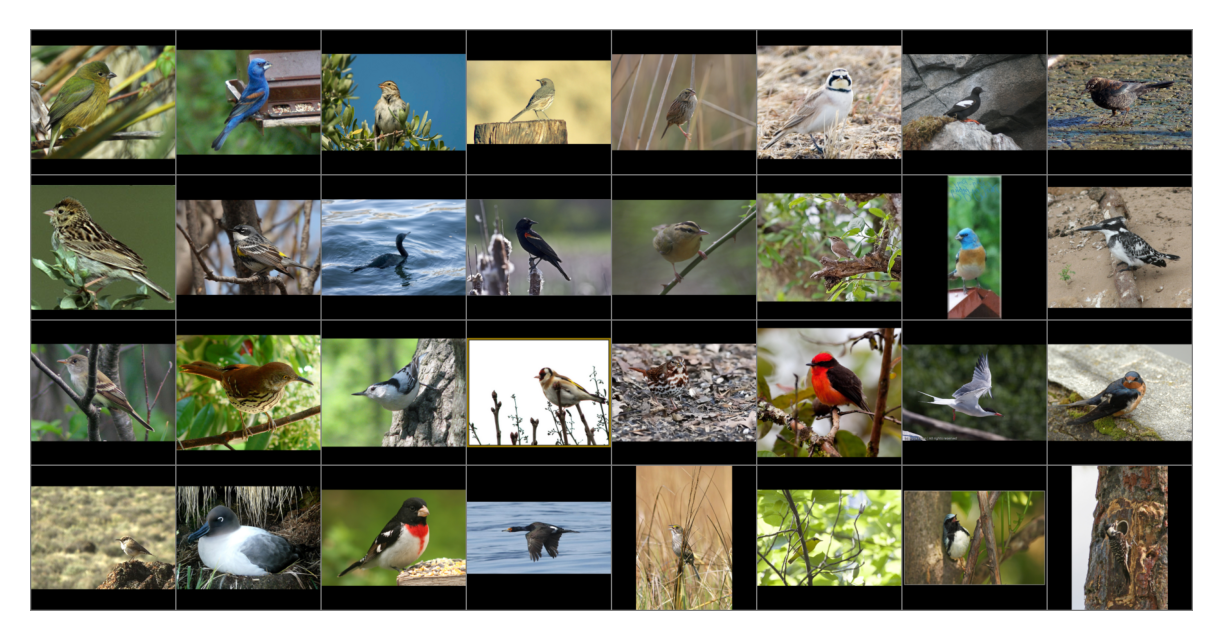

tensor([ 16,  54, 115, 150, 123,  85,  58,  11, 113, 171,  25,  10, 181, 193,
         15,  81,  39, 149,  94,  48, 120,  42, 144, 136, 198,   3,  57,  24,
        128, 168, 160, 190])


In [66]:
# functions to show an image
def imshow(img):
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.rcParams['figure.dpi'] = 300
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
img, tokens, lbl = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(img))
print(lbl)